In [ ]:
!wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip
!unzip Projet+Mise+en+prod+-+home-credit-default-risk.zip > /dev/null 2>&1

--2022-03-17 16:46:53--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.89.139
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.89.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 721615855 (688M) [application/zip]
Saving to: ‘Projet+Mise+en+prod+-+home-credit-default-risk.zip’

Projet+Mise+en+prod 100%[===================>] 688.19M  20.3MB/s    in 36s     

2022-03-17 16:47:30 (18.9 MB/s) - ‘Projet+Mise+en+prod+-+home-credit-default-risk.zip’ saved [721615855/721615855]



# Data processing

In [ ]:
#Importation de quelques librairies utiles 
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')

In [ ]:

df = pd.read_csv("application_train.csv")
df_bureau = pd.read_csv("bureau.csv")
df_previous_app = pd.read_csv("previous_application.csv")
df_installments = pd.read_csv("installments_payments.csv")

key = "SK_ID_CURR"
bureau_cols = ["DAYS_CREDIT", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT"]
bureau_cols_max = ["BUREAU_MAX_" + c for c in bureau_cols]

df = pd.merge(
    left=df,
    right=df_bureau[[key] + bureau_cols]
    .groupby(key)
    .max()
    .rename(columns=dict(zip(bureau_cols, bureau_cols_max))),
    left_on=key,
    right_index=True,
    how="left",
)

key_prev = "SK_ID_PREV"
payment_cols = ["AMT_PAYMENT"]

# Min payment for all previous loans
df_previous_app = pd.merge(
    left=df_previous_app,
    right=df_installments[[key_prev] + payment_cols].groupby(key_prev).min(),
    left_on=key_prev,
    right_index=True,
    how="left",
)

key = "SK_ID_CURR"
prev_agg_cols = ["PREV_SUM_MIN_AMT_PAYMENT", "PREV_MEAN_MIN_AMT_PAYMENT"]

# Sum and mean of minimum payments across all previous loans
df_prev_agg = df_previous_app[[key] + payment_cols].groupby(key).agg(["sum", "mean"])
df_prev_agg.columns = prev_agg_cols

df = pd.merge(left=df, right=df_prev_agg, left_on=key, right_index=True, how="left")

base_cols = [
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "DAYS_BIRTH",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "DAYS_EMPLOYED",
    "AMT_GOODS_PRICE",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
]
feature_cols = base_cols + bureau_cols_max + prev_agg_cols
y = df.TARGET
X = df[feature_cols + ["SK_ID_CURR", "TARGET"]]
X = X.fillna(value=X.mean())





In [ ]:
X.to_csv("cleaned_data.csv", index=False)
X = pd.read_csv("cleaned_data.csv")
X = X.set_index('SK_ID_CURR')
X.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_ID_PUBLISH,OWN_CAR_AGE,BUREAU_MAX_DAYS_CREDIT,BUREAU_MAX_DAYS_CREDIT_ENDDATE,BUREAU_MAX_DAYS_ENDDATE_FACT,PREV_SUM_MIN_AMT_PAYMENT,PREV_MEAN_MIN_AMT_PAYMENT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,
100002,0.083037,0.262949,0.139376,-9461,406597.5,24700.5,-637,351000.0,-2120,12.061091,-103.000000,780.000000,-36.000000,9251.775,9251.775,1
100003,0.311267,0.622246,0.510853,-16765,1293502.5,35698.5,-1188,1129500.0,-291,12.061091,-606.000000,1216.000000,-540.000000,169295.580,56431.860,0
100004,0.502130,0.555912,0.729567,-19046,135000.0,6750.0,-225,135000.0,-2531,26.000000,-408.000000,-382.000000,-382.000000,5357.250,5357.250,0
100006,0.502130,0.650442,0.510853,-19005,312682.5,29686.5,-3039,297000.0,-2437,12.061091,-489.297817,4433.041953,-526.985948,723297.330,241099.110,0
100007,0.502130,0.322738,0.510853,-19932,513000.0,21865.5,-3038,513000.0,-3458,12.061091,-1149.000000,-783.000000,-783.000000,33928.830,6785.766,0


In [ ]:
# Permet l'affichage de 500 lignes et de 500 colonnes
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [ ]:
#Taux des valeurs manquantes pour chaque variable trié de 0 à 1
df.isna().mean().sort_values()


SK_ID_CURR                        0.000000
HOUR_APPR_PROCESS_START           0.000000
REG_REGION_NOT_LIVE_REGION        0.000000
REG_REGION_NOT_WORK_REGION        0.000000
LIVE_REGION_NOT_WORK_REGION       0.000000
REG_CITY_NOT_LIVE_CITY            0.000000
REG_CITY_NOT_WORK_CITY            0.000000
LIVE_CITY_NOT_WORK_CITY           0.000000
ORGANIZATION_TYPE                 0.000000
FLAG_DOCUMENT_19                  0.000000
FLAG_DOCUMENT_18                  0.000000
FLAG_DOCUMENT_17                  0.000000
FLAG_DOCUMENT_16                  0.000000
REGION_RATING_CLIENT_W_CITY       0.000000
FLAG_DOCUMENT_15                  0.000000
FLAG_DOCUMENT_13                  0.000000
FLAG_DOCUMENT_12                  0.000000
FLAG_DOCUMENT_11                  0.000000
FLAG_DOCUMENT_10                  0.000000
FLAG_DOCUMENT_9                   0.000000
FLAG_DOCUMENT_8                   0.000000
FLAG_DOCUMENT_7                   0.000000
FLAG_DOCUMENT_6                   0.000000
FLAG_DOCUME

In [ ]:
dfX=df[["EXT_SOURCE_1",                      
"EXT_SOURCE_2",                      
"EXT_SOURCE_3",                      
"DAYS_BIRTH",                        
"AMT_CREDIT",                        
"AMT_ANNUITY",                      
"DAYS_EMPLOYED",                    
"AMT_GOODS_PRICE",                  
"DAYS_ID_PUBLISH",                   
"OWN_CAR_AGE",                      
"BUREAU_MAX_DAYS_CREDIT",            
"BUREAU_MAX_DAYS_CREDIT_ENDDATE",    
"BUREAU_MAX_DAYS_ENDDATE_FACT",      
"PREV_SUM_MIN_AMT_PAYMENT",         
"PREV_MEAN_MIN_AMT_PAYMENT", 
"TARGET"       
]]

In [ ]:
#Taux des valeurs manquantes pour chaque variable trié de 0 à 1
dfX.isna().mean().sort_values()


DAYS_BIRTH                        0.000000
AMT_CREDIT                        0.000000
DAYS_EMPLOYED                     0.000000
DAYS_ID_PUBLISH                   0.000000
TARGET                            0.000000
AMT_ANNUITY                       0.000039
AMT_GOODS_PRICE                   0.000904
EXT_SOURCE_2                      0.002146
PREV_SUM_MIN_AMT_PAYMENT          0.053507
PREV_MEAN_MIN_AMT_PAYMENT         0.058902
BUREAU_MAX_DAYS_CREDIT            0.143149
BUREAU_MAX_DAYS_CREDIT_ENDDATE    0.150463
EXT_SOURCE_3                      0.198253
BUREAU_MAX_DAYS_ENDDATE_FACT      0.250905
EXT_SOURCE_1                      0.563811
OWN_CAR_AGE                       0.659908
dtype: float64

In [ ]:
#Taux des valeurs manquantes pour chaque variable trié de 0 à 1
#X a subit une imputation des valeurs manquantes par la moyenne de chaque variable
X.isna().mean().sort_values()

EXT_SOURCE_1                      0.0
EXT_SOURCE_2                      0.0
EXT_SOURCE_3                      0.0
DAYS_BIRTH                        0.0
AMT_CREDIT                        0.0
AMT_ANNUITY                       0.0
DAYS_EMPLOYED                     0.0
AMT_GOODS_PRICE                   0.0
DAYS_ID_PUBLISH                   0.0
OWN_CAR_AGE                       0.0
BUREAU_MAX_DAYS_CREDIT            0.0
BUREAU_MAX_DAYS_CREDIT_ENDDATE    0.0
BUREAU_MAX_DAYS_ENDDATE_FACT      0.0
PREV_SUM_MIN_AMT_PAYMENT          0.0
PREV_MEAN_MIN_AMT_PAYMENT         0.0
TARGET                            0.0
dtype: float64

In [ ]:
X.shape

(307511, 16)

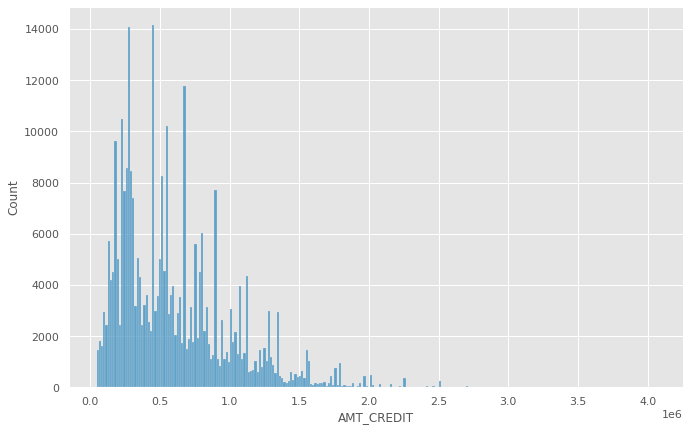

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="AMT_CREDIT")


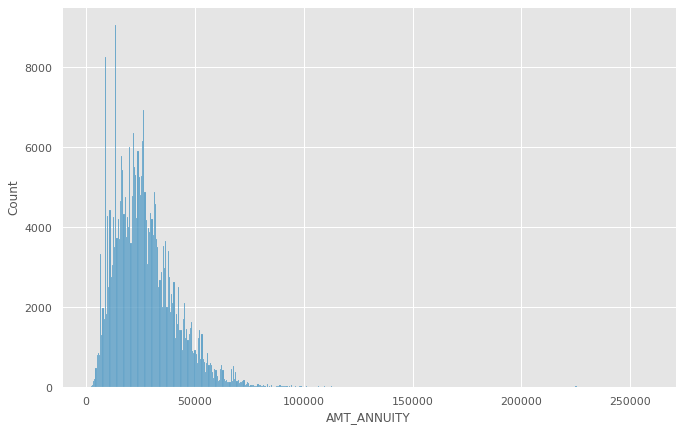

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="AMT_ANNUITY")

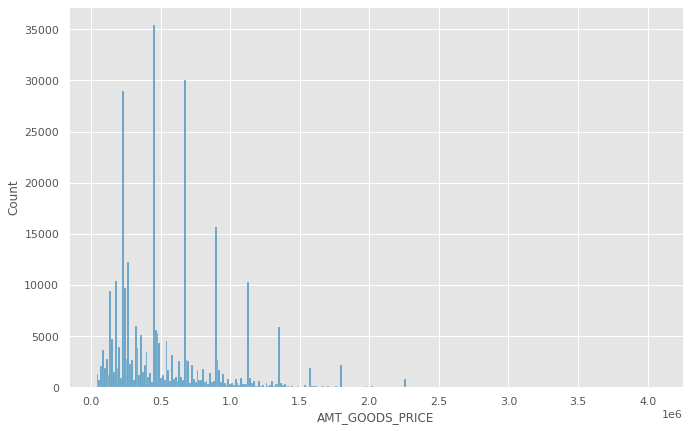

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="AMT_GOODS_PRICE")

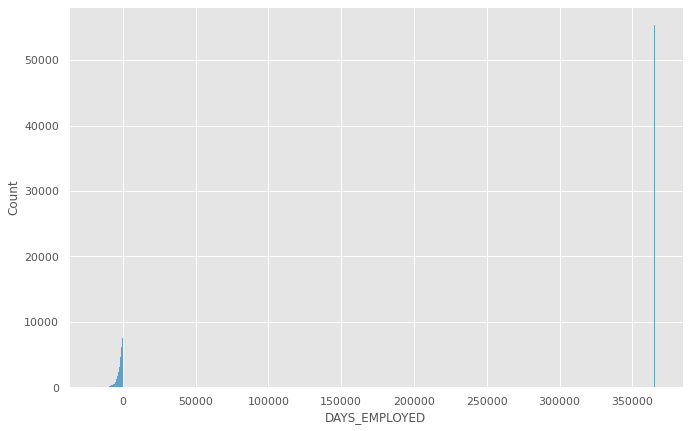

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="DAYS_EMPLOYED")

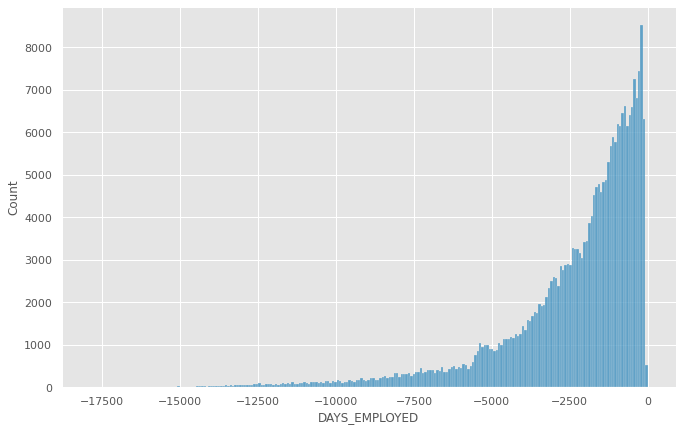

In [ ]:
new_X=X[X["DAYS_EMPLOYED"]<=0]
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=new_X, x="DAYS_EMPLOYED")

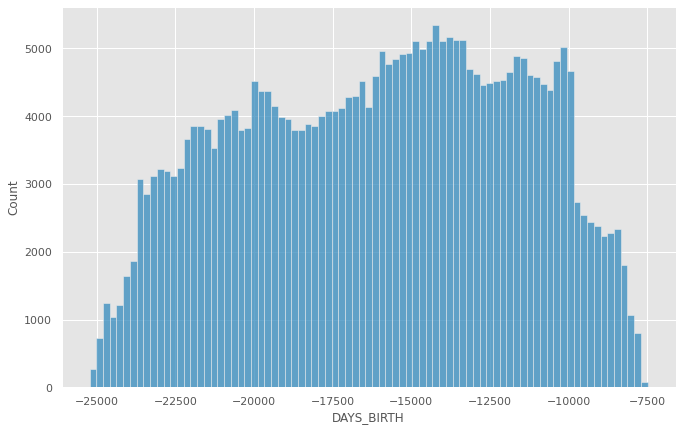

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="DAYS_BIRTH")                    

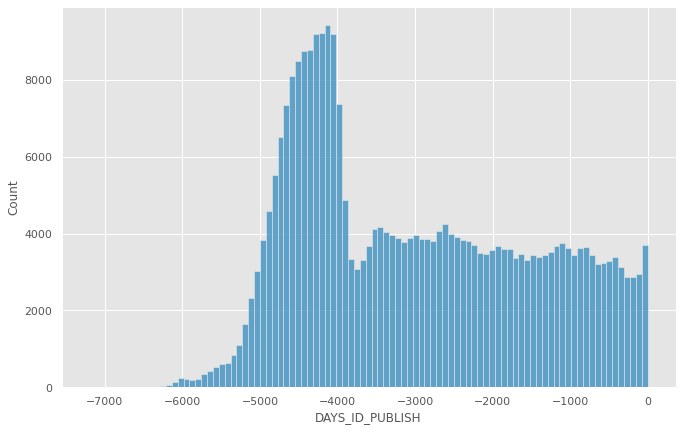

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="DAYS_ID_PUBLISH") 

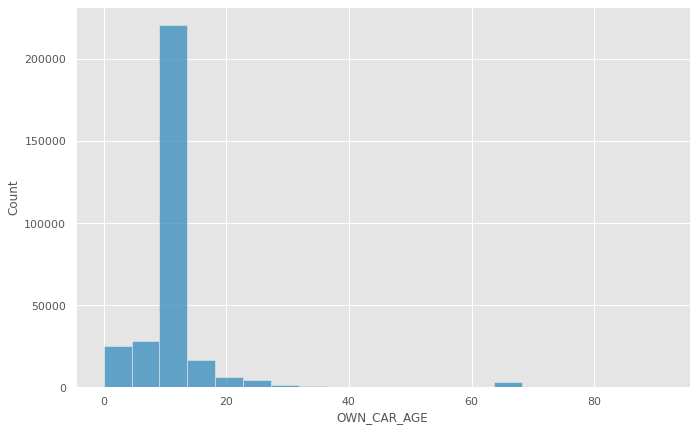

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="OWN_CAR_AGE") 

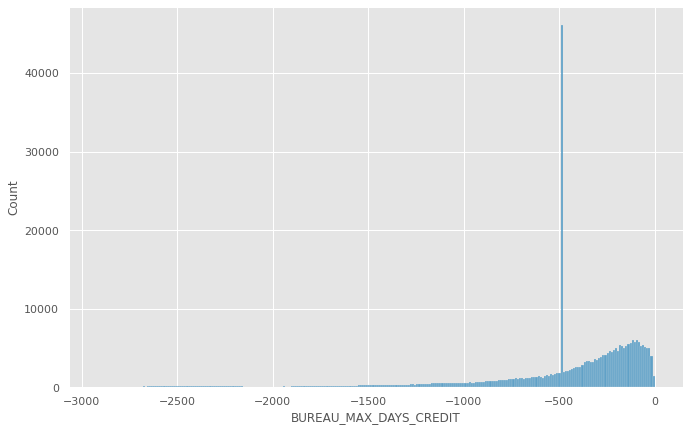

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="BUREAU_MAX_DAYS_CREDIT")          

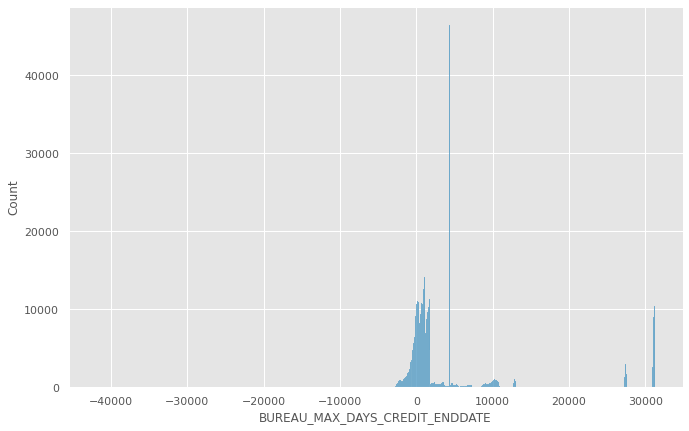

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="BUREAU_MAX_DAYS_CREDIT_ENDDATE") 

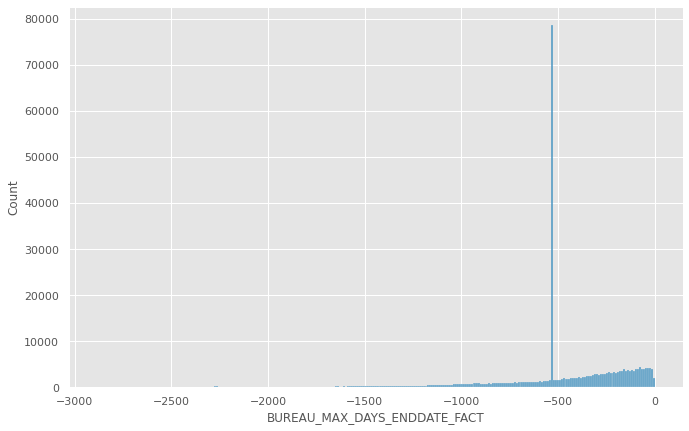

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="BUREAU_MAX_DAYS_ENDDATE_FACT") 

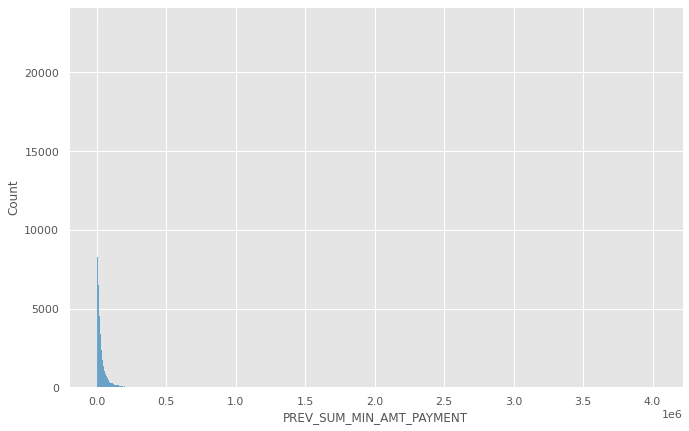

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="PREV_SUM_MIN_AMT_PAYMENT") 

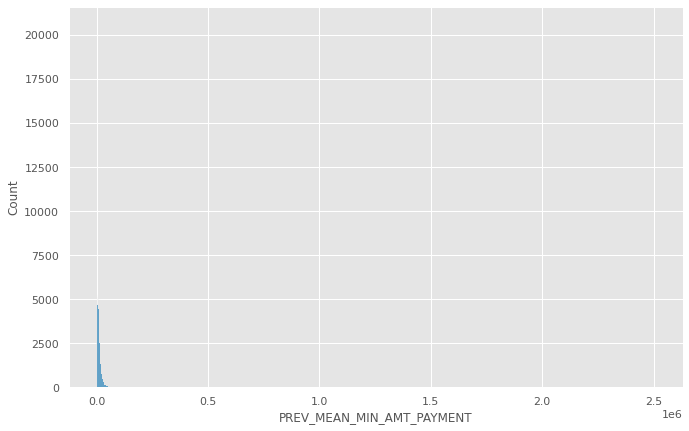

In [ ]:
plt.figure(figsize=(11,7)) # CHANGE la taille du graphique
sns.histplot(data=X, x="PREV_MEAN_MIN_AMT_PAYMENT") 

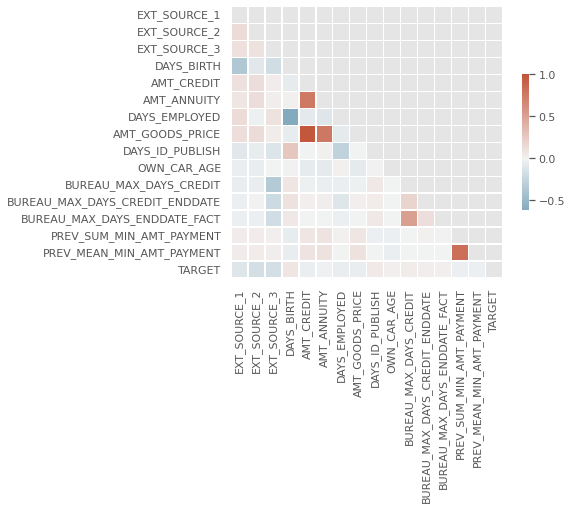

In [ ]:
# Compute the correlation matrix
corr = X[["EXT_SOURCE_1",                      
"EXT_SOURCE_2",                      
"EXT_SOURCE_3",                      
"DAYS_BIRTH",                        
"AMT_CREDIT",                        
"AMT_ANNUITY",                      
"DAYS_EMPLOYED",                    
"AMT_GOODS_PRICE",                  
"DAYS_ID_PUBLISH",                   
"OWN_CAR_AGE",                      
"BUREAU_MAX_DAYS_CREDIT",            
"BUREAU_MAX_DAYS_CREDIT_ENDDATE",    
"BUREAU_MAX_DAYS_ENDDATE_FACT",      
"PREV_SUM_MIN_AMT_PAYMENT",         
"PREV_MEAN_MIN_AMT_PAYMENT",  
"TARGET"      
]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Balanced data with smote

In [ ]:
!pip install imbalanced-learn > /dev/null 2>&1

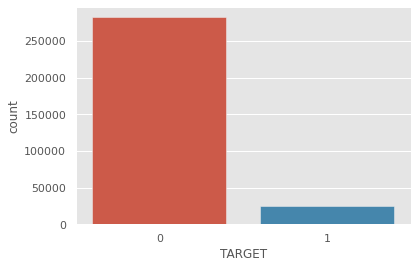

In [ ]:
import seaborn as sns
sns.countplot(data=X, x='TARGET')

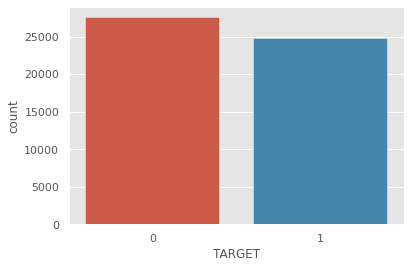

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy=0.9)
X_undersampled, y_undersampled = rus.fit_resample(X, y)
X_undersampled = pd.DataFrame(X_undersampled, columns=X.columns)
sns.countplot(data=X_undersampled, x='TARGET')

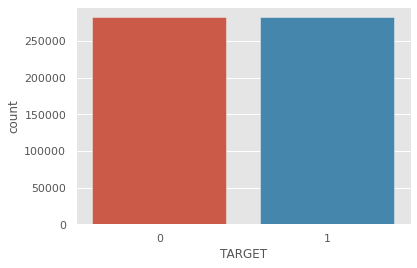

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
X_oversampled, y_oversampled = sm.fit_resample(X, y)
X_oversampled = pd.DataFrame(X_oversampled, columns=X.columns)
sns.countplot(data=X_oversampled, x='TARGET')

# Model training

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split

#Séparons nos données en un jeu de test et un jeu d'entraînement :
X_train, X_test, y_train, y_test = train_test_split(X[feature_cols], y, test_size=0.2)

#Standardisons les données :
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

pipeline = imbpipeline(steps = [['undersampling', RandomUnderSampler(sampling_strategy=0.5)],
                                ['smote', SMOTE(n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', RandomForestClassifier()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__max_features':['auto']}
#Create new score
ften_scorer = make_scorer(fbeta_score, beta=10)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=ften_scorer,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.5461283295617627
Test score: 0.5623223742448479


In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

#Calculons l'accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy score : {:.2f}".format( accuracy_score(y_test, y_pred)))

Accuracy score : 0.74


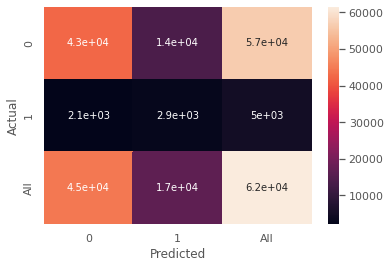

In [ ]:
# Calcul de la matrice de confusion

results = pd.DataFrame()
results['targettrue']=y_test
results['targetpred']=y_pred

confusion_matrix = pd.crosstab(results['targettrue'], results['targetpred'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

No handles with labels found to put in legend.


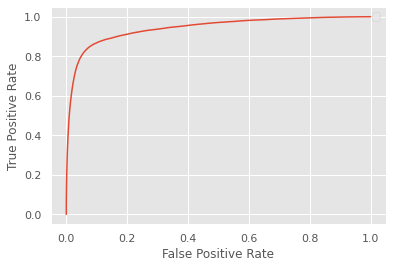

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
probs = grid_search.predict_proba(X[feature_cols])
# keep probabilities for the positive outcome only
probs = probs[:, 1]
fpr, tpr, _ = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = imbpipeline(steps = [['undersampling', RandomUnderSampler(sampling_strategy=0.5)],
                                ['smote', SMOTE(n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', GradientBoostingClassifier()]])
   
param_grid = {'classifier__max_features':['auto']}


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=ften_scorer,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6093836856938716
Test score: 0.6117404657310578


In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

#Calculons l'accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy score : {:.2f}".format( accuracy_score(y_test, y_pred)))

Accuracy score : 0.71


No handles with labels found to put in legend.


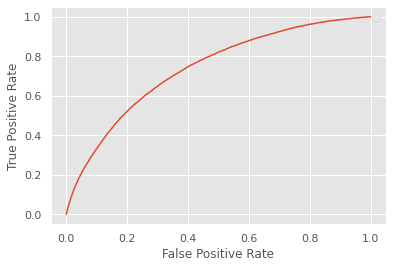

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
probs = grid_search.predict_proba(X[feature_cols])
# keep probabilities for the positive outcome only
probs = probs[:, 1]
fpr, tpr, _ = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
grid_search.best_params_

{'classifier__max_features': 'auto'}

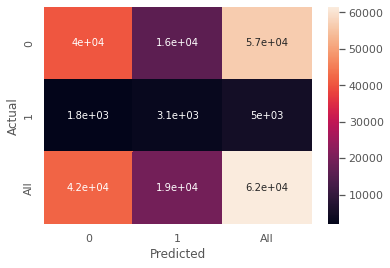

In [ ]:
# Calcul de la matrice de confusion

results = pd.DataFrame()
results['targettrue']=y_test
results['targetpred']=y_pred

confusion_matrix = pd.crosstab(results['targettrue'], results['targetpred'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
import pickle

df_predictions = pd.DataFrame()
df_predictions["SK_ID_CURR"] = X.index
df_predictions[["no", "yes"]] = grid_search.predict_proba(X[feature_cols])

fi = pd.DataFrame(
    {"feature": list(feature_cols), "importance": grid_search.best_estimator_["classifier"].feature_importances_}
).sort_values("importance", ascending=False)

df_predictions.to_csv("predictions.csv")
fi.to_csv("features_importance.csv")

# enregistrer le model
filename = 'final_model.pkl'
pickle.dump(grid_search.best_estimator_, open(filename, 'wb'))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

pipeline = imbpipeline(steps = [['undersampling', RandomUnderSampler(sampling_strategy=0.9)],
                                ['smote', SMOTE(n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', KNeighborsClassifier()]])
   
param_grid = {'classifier__n_neighbors': list(range(5,10))}


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=ften_scorer,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6302601391143171
Test score: 0.6340071298181228


In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

#Calculons l'accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy score : {:.2f}".format( accuracy_score(y_test, y_pred)))

Accuracy score : 0.62


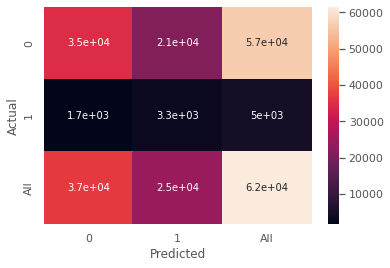

In [ ]:
# Calcul de la matrice de confusion

results = pd.DataFrame()
results['targettrue']=y_test
results['targetpred']=y_pred

confusion_matrix = pd.crosstab(results['targettrue'], results['targetpred'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

No handles with labels found to put in legend.


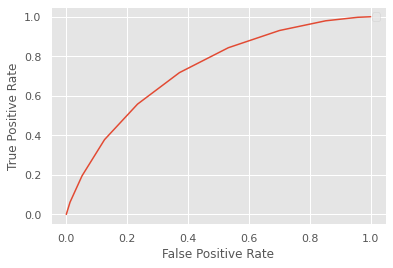

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
probs = grid_search.predict_proba(X[feature_cols])
# keep probabilities for the positive outcome only
probs = probs[:, 1]
fpr, tpr, _ = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:

from sklearn.svm import LinearSVC

pipeline = imbpipeline(steps = [['undersampling', RandomUnderSampler(sampling_strategy=0.5)],
                                ['smote', SMOTE(n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LinearSVC()]])
   
param_grid = {'classifier__tol': [1e-3,1e-4,1e-5,1e-6]}


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=ften_scorer,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6289243184747499
Test score: 0.634486581366345


In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

#Calculons l'accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy score : {:.2f}".format( accuracy_score(y_test, y_pred)))

Accuracy score : 0.68


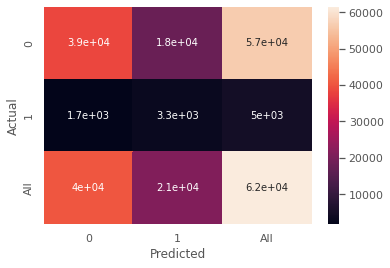

In [ ]:
# Calcul de la matrice de confusion

results = pd.DataFrame()
results['targettrue']=y_test
results['targetpred']=y_pred

confusion_matrix = pd.crosstab(results['targettrue'], results['targetpred'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

pipeline = imbpipeline(steps = [['undersampling', RandomUnderSampler(sampling_strategy=0.5)],
                                ['smote', SMOTE(n_jobs=-1)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression()]])
   
param_grid = {'classifier__penalty': ['l2', 'none']}


grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring=ften_scorer,
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6313191935672285
Test score: 0.6363006607887132


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X_test)

#Calculons l'accuracy score
from sklearn.metrics import accuracy_score
print("Accuracy score : {:.2f}".format( accuracy_score(y_test, y_pred)))

Accuracy score : 0.68


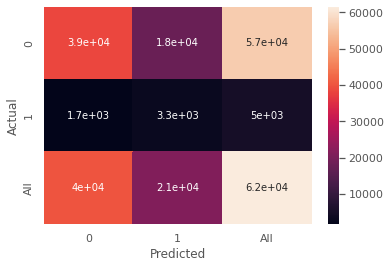

In [ ]:
# Calcul de la matrice de confusion

results = pd.DataFrame()
results['targettrue']=y_test
results['targetpred']=y_pred

confusion_matrix = pd.crosstab(results['targettrue'], results['targetpred'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sns.heatmap(confusion_matrix, annot=True)
plt.show()

No handles with labels found to put in legend.


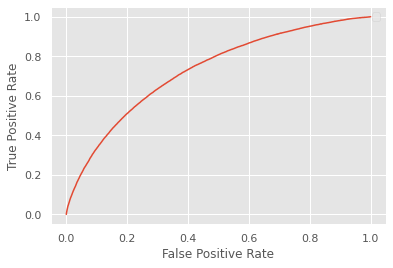

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
probs = grid_search.predict_proba(X[feature_cols])
# keep probabilities for the positive outcome only
probs = probs[:, 1]
fpr, tpr, _ = roc_curve(y, probs)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()